<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Monte_Carlo_Candlestick_Chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade mplfinance
!pip install --upgrade pandas_ta

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas_ta as ta
import datetime as dt

In [3]:
mu = 0.05
sigma = 0.07
S0 = 100
days = 500

In [4]:
def plot_candle_sticks_macd(mu, sigma, S0, days):
    price_df = pd.DataFrame({
        'n' : np.arange(24 * 60 * days),
        'W' : np.cumsum(np.random.normal(size = 24 * 60 * days))
    })

    delta_t = 1.0/(365.0 * 24 * 60)

    price_df.eval('S = @S0 * exp((@mu - 0.5 * @sigma ** 2) *n * @delta_t + @sigma * sqrt(@delta_t) * W)', inplace = True)

    candle_arr = price_df['S'].values.reshape([-1, 24 * 60])
    candlestick_df = pd.DataFrame({
        'Open' : candle_arr[:, 0],
        'High' : np.max(candle_arr, axis = 1, keepdims = False),
        'Low' : np.min(candle_arr, axis = 1, keepdims = False),
        'Close' : candle_arr[:, -1]
    }, index = pd.date_range(start="2023-01-01", periods = days))

    # Step 2: Calculate technical indicators using pandas-ta
    multiple_ema = pd.concat(
        [
            candlestick_df,
            candlestick_df.ta.kc(high = "High", low = "Low", close = "Close", length=20, multiplier=2),
            candlestick_df.ta.supertrend(high = "High", low = "Low", close = "Close", length=10, multiplier=3),
            candlestick_df.ta.macd(close="Close", fast=12, slow=26, signal=9),
            candlestick_df.ta.rsi(close="Close", length=14)
        ],
        axis = 1
    )

    data_df = multiple_ema
    display(data_df)

    plots = [
        mpf.make_addplot(data_df["SUPERTs_10_3.0"], color="red"),
        mpf.make_addplot(data_df["SUPERTl_10_3.0"], color="green"),
        mpf.make_addplot(data_df["MACD_12_26_9"], panel=1, color="blue", ylabel="MACD"),
        mpf.make_addplot(data_df["MACDs_12_26_9"], panel=1, color="orange"),
        mpf.make_addplot(
            data_df["MACDh_12_26_9"],
            type="bar",
            panel=1,
            color=["green" if val >= 0 else "red" for val in data_df["MACDh_12_26_9"]],
            alpha=0.5,
        ),
        mpf.make_addplot(data_df["RSI_14"], panel=2, color="purple", ylabel="RSI"),
    ]

    mpf.plot(
        data_df,
        type="candle",  # Candlestick chart
        style="yahoo",  # Chart style
        addplot=plots,
        figscale = 4,
        panel_ratios=(3, 1, 1)
    )

,Open,High,Low,Close,KCLe_20_2,KCBe_20_2,KCUe_20_2,SUPERT_10_3.0,SUPERTd_10_3.0,SUPERTl_10_3.0,SUPERTs_10_3.0,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14
2023-01-01,99.998395,100.707863,99.996506,100.705948,NaN,NaN,NaN,0.000000,1,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,100.694925,100.702920,100.291122,100.461913,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,100.450959,101.043903,100.385681,100.932509,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04,100.928767,101.580970,100.860042,101.291919,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-05,101.289622,101.458631,100.924836,100.984992,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-10,114.126623,114.188859,113.367576,113.544136,112.855525,114.327722,115.799918,113.176888,1,113.176888,NaN,0.297662,-0.169074,0.466736,44.000225
2024-05-11,113.559190,114.237121,113.429067,114.225257,112.832061,114.317963,115.803866,113.176888,1,113.176888,NaN,0.256404,-0.168266,0.424670,50.743579
2024-05-12,114.219505,114.324705,113.659111,113.910387,112.807979,114.279146,115.750314,113.176888,1,113.176888,NaN,0.196039,-0.182905,0.378944,47.873611
2024-05-13,113.889930,114.371348,113.675968,114.281526,112.815863,114.279373,115.742883,113.176888,1,113.176888,NaN,0.176117,-0.162261,0.338378,51.365278


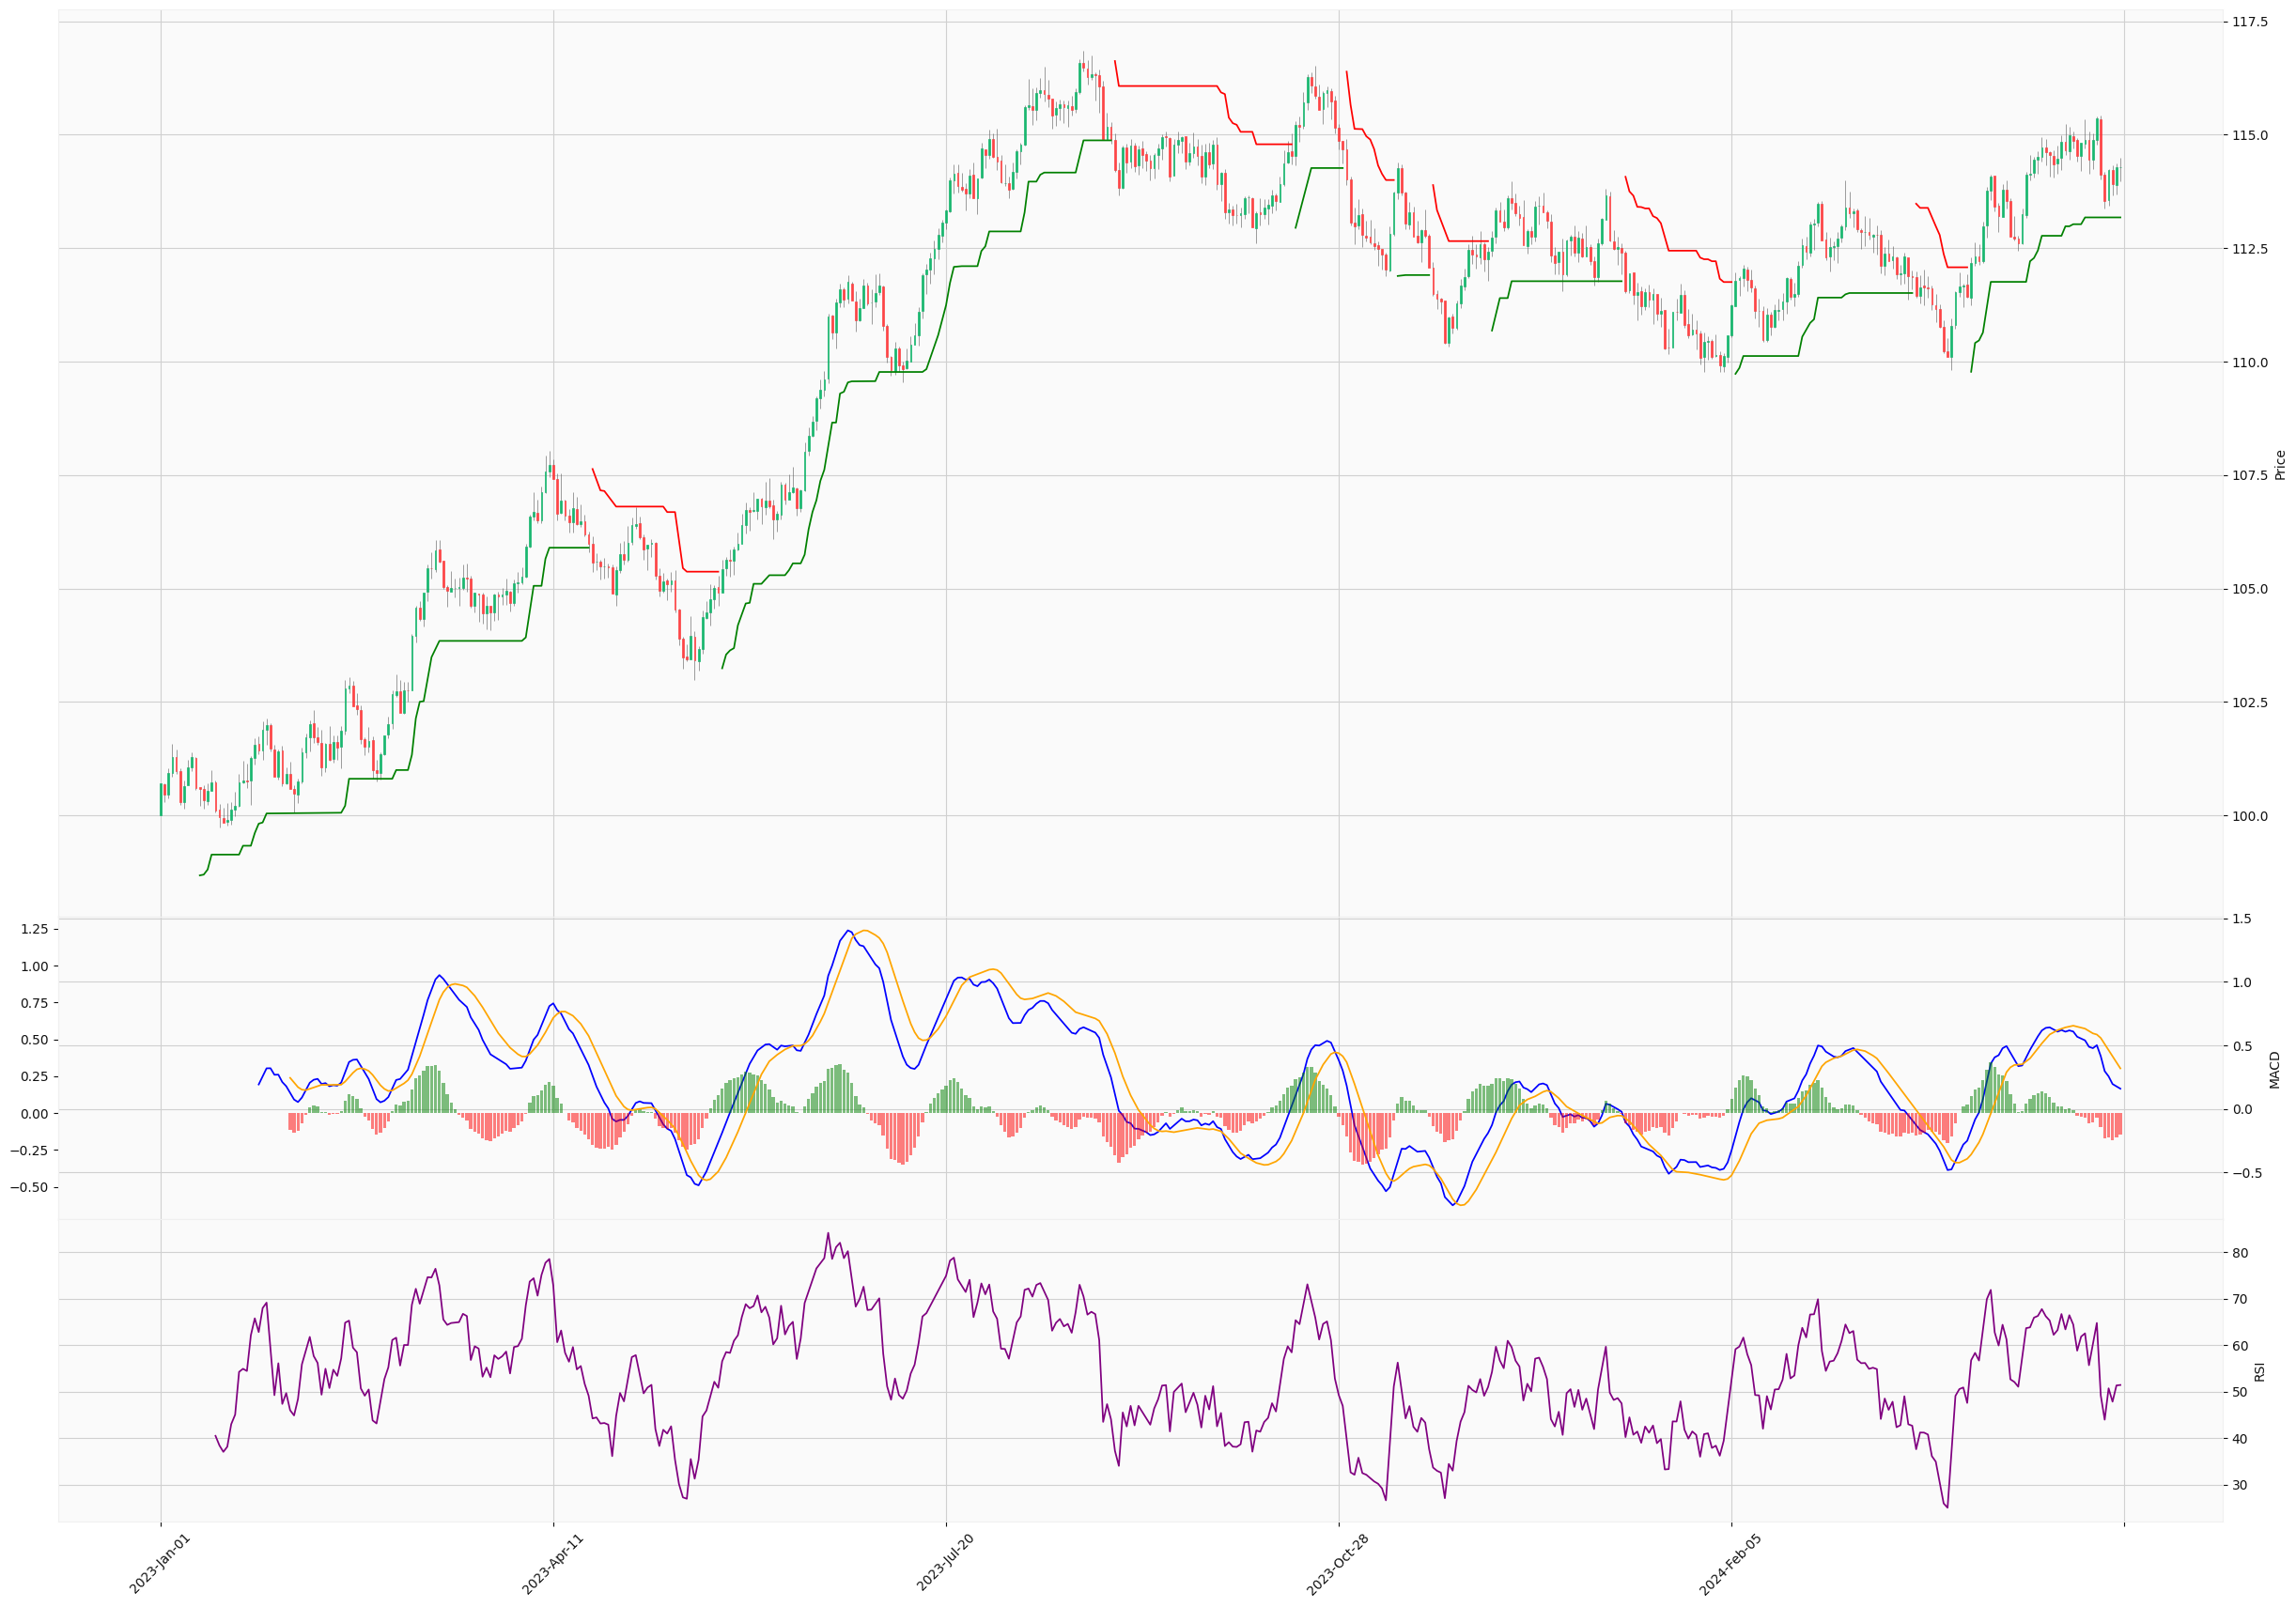

In [5]:
plot_candle_sticks_macd(mu, sigma, S0, days)